#Import library

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
plt.rcParams["figure.figsize"] = (10, 10)

In [ ]:
from collections.abc import Callable
Vector = np.array
Matrix = np.array
Function = Callable[[float, Vector], Vector]

#Loading data

In [ ]:
#https://raw.githubusercontent.com/your-username/name-of-the-repository/master/name-of-the-file.xlsx
data = pd.read_excel("https://raw.githubusercontent.com/PDucMinh/Stock-Predict/master/exact.xlsx")

In [ ]:
def explicit_euler(f: Function, t: float, x: Vector, h: float) -> Vector: 
  h=0.001 
  return x + f(t,x)*h

In [ ]:
data.rename(columns={str(data.columns[0]):"t"},inplace=True)
data.eval("t=t+1",inplace=True)
data.eval("t=t*0.001",inplace=True)
test = data.to_numpy()
t = test[:,0]
R = test[:,1]
J = test[:,2]

#Denoising

In [ ]:
t_feature = np.vander(t,20)
denoiser = BayesianRidge(tol=1e-6 , fit_intercept = False , compute_score = True)
denoiser.set_params(alpha_init = 1.0 , lambda_init = 0.001)

BayesianRidge(alpha_init=1.0, compute_score=True, fit_intercept=False,
              lambda_init=0.001, tol=1e-06)

In [ ]:
denoiser.fit(t_feature, R)
R_mean, R_std = denoiser.predict(t_feature , return_std = True)

In [ ]:
denoiser.fit(t_feature, J)
J_mean, J_std = denoiser.predict(t_feature, return_std = True)

#Calculate derivative

In [ ]:
R_ = [(R_mean [0] + 2)/0.001]
J_ = [(J_mean [0] - 3)/0.001]
for i in range (1, 1000, 1):
  R_.append((R_mean[i] - R_mean[i-1])/0.001)
  J_.append((J_mean[i] - J_mean[i-1])/0.001)

In [ ]:
def Forward_Euler(R_0, J_0, W, h):
  a = W[0, 0]
  b = W[1, 0]
  c = W[2, 0]
  d = W[3, 0]

  R_pred = [R_0]
  J_pred = [J_0]
  for i in range (1000):
    R_st = R_pred[len(R_pred) - 1]
    J_st = J_pred[len(J_pred) - 1]
    R_nd = R_st + (a*R_st+b*J_st)*h
    J_nd = J_st + (c*R_st+d*J_st)*h
    R_pred.append(R_nd)
    J_pred.append(J_nd)
  return R_pred, J_pred

#Setting LR model

In [ ]:
model = LinearRegression()
train_size = 600
X = np.hstack([R_mean.reshape(-1,1),J_mean.reshape(-1,1)])
model.fit(X[:train_size,:],R_[:train_size])
reg_W = model.coef_
model.fit(X[:train_size,:],J_[:train_size])
reg_W = np.hstack([reg_W, model.coef_]).reshape(-1, 1)

In [ ]:
R_pred, J_pred = Forward_Euler(-2, 3, reg_W, 0.001) 

In [ ]:
#mean squared error
print(np.mean((R_pred[1:]-R) ** 2 + (J_pred[1:]-J)**2))

9.93029878970842


#Answer

In [ ]:
print(reg_W)

[[ 2.19377225]
 [ 3.75121612]
 [ 5.36361747]
 [-2.45878631]]


#Plot

In [ ]:
matrix = reg_W.reshape(2, 2)

In [ ]:
def explicit_euler(f: Function, t: float, x: Vector, h: float) -> Vector:
  return x + f(t,x)*h

In [ ]:
def result(t: float, x: Vector) -> Vector:
  matrix = reg_W.reshape(2, 2)
  constant_case = Matrix(matrix, dtype=float)
  return np.matmul(constant_case, x)

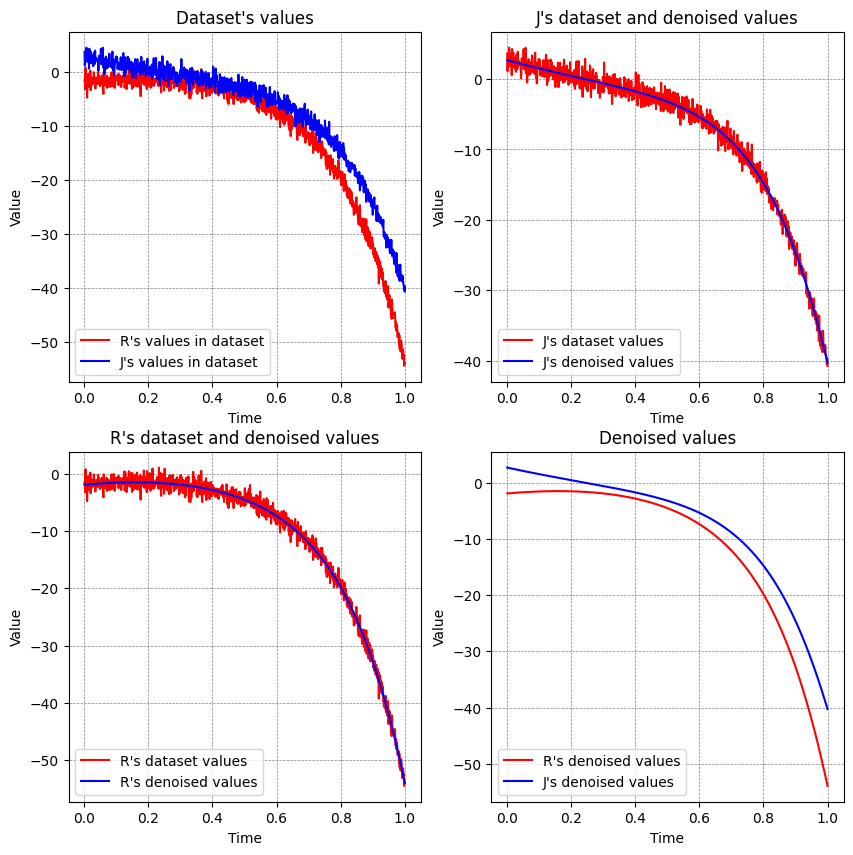

In [ ]:
plt.subplot(2,2,1)
plt.plot(t, R, color = 'red', label = 'R\'s values in dataset')
plt.plot(t, J, color = 'blue', label = 'J\'s values in dataset')
plt.title('Dataset\'s values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

plt.subplot(2,2,3)
plt.plot(t, R, color = 'red', label = 'R\'s dataset values')
plt.plot(t, R_mean, color = 'blue', label = 'R\'s denoised values')
plt.title('R\'s dataset and denoised values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

plt.subplot(2,2,2)
plt.plot(t, J, color = 'red', label = 'J\'s dataset values')
plt.plot(t, J_mean, color = 'blue', label = 'J\'s denoised values')
plt.title('J\'s dataset and denoised values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

plt.subplot(2,2,4)
plt.plot(t, R_mean, color = 'red', label = 'R\'s denoised values')
plt.plot(t, J_mean, color = 'blue', label = 'J\'s denoised values')
plt.title('Denoised values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

plt.show()